# Ridge training in dual form

Here we take the following approach to learning. The dual form of the dynamics is:

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{f}^{base}(\mathbf{x}) + B\mathbf{u} + C \sum_{j} \boldsymbol{\alpha}^j k(\mathbf{x}, \mathbf{x}_j^*).$$

Define the Loss function as the error between the true and target velocity fields given a set of locations and inputs:

$$\mathcal{L}(\{(\mathbf{x}^*, \boldsymbol{\alpha})\}; \{(\mathbf{v}, \mathbf{x}, \mathbf{u})^i\}) \equiv \sum_i \| \mathbf{v}^i - \mathbf{F}\left(\mathbf{x}^i, \mathbf{u}^i; \{(\mathbf{x}^*, \boldsymbol{\alpha})\}\right)\|^2$$

where $\mathbf{F} \equiv \frac{d\mathbf{x}}{dt}.$

For a fixed set of $\mathbf{x}^*$ this can be formulated as a linear regression problem in $\boldsymbol{\alpha}$. For simplicity let $C = I$. Then the component $d$ of the flow field is given via

$$\tau v_d^i = -x_d^i + f_d^{base}(\mathbf{x}^i) + (B\mathbf{u}^i)_d + \sum_{j} \alpha_d^jk(\mathbf{x}^i, \mathbf{x}_j^*)$$

i.e.

$$y_d^i \equiv \tau v_d^i + x_d^i - f_d^{base}(\mathbf{x}^i) - (B\mathbf{u}^i)_d = \sum_{\mathbf{x}^*} \alpha_d(\mathbf{x}^*)k(\mathbf{x}^i, \mathbf{x}^*)$$

where we note that the RHS is just a dot product.

Thus, letting 

$$\mathbf{y}_d \equiv [y_d^1, \dots y_d^N]^T \quad \text{and} \quad
\boldsymbol{\alpha}_d \equiv [\alpha_d^1, \dots, \alpha_d^P]^T \quad \text{and} \quad
K \equiv \begin{bmatrix}
k(\mathbf{x}^1, \mathbf{x}_1^*) & \cdots & k(\mathbf{x}^1, \mathbf{x}_P^*) \\
\vdots & \cdots & \vdots \\
k(\mathbf{x}^N, \mathbf{x}_1^*) & \cdots & k(\mathbf{x}^N, \mathbf{x}_P^*) \\
\end{bmatrix}
$$

we can write

$$K\boldsymbol{\alpha}_d = \mathbf{y}_d$$

which we can solve using e.g. Ridge regression.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge

from aux import get_flow
from kernels import make_psi_rand_tanh_k_wta, make_psi_rand_tanh, make_psi_rand_lin, make_psi_rand_sgm
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 21)
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 1
J_PSI = G*np.random.randn(N, D)

# psi_name = 'rand_lin'
# psi, ker = make_psi_rand_lin(J_PSI)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)

# psi_name = 'rand_tanh_kwta'
# K = 50
# psi, ker = make_psi_rand_tanh_k_wta(J_PSI, K)

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj(x_stars, alphas, x_init, t):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], np.zeros(D), x_stars, alphas)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

In [3]:
def plot_quivers(x_stars_all, alphas_all, u=None, arrow_scale=.5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, x_stars_all[0], alphas_all[0])
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    
    for x_star, alpha in zip(x_stars_all[0], alphas_all[0]):
        axs[1].scatter(*x_star, c='r')
        axs[1].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, x_stars_all[-1], alphas_all[-1])
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[2].scatter(*x_star, c='r')
        axs[2].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

    quiver(axs[3], flow_post-flow_base, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[3].scatter(*x_star, c='r')
        axs[3].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs
    
    
def plot_trjs(x_stars, alphas, x_inits, t):
    fig, axs = plt.subplots(1, len(x_inits), figsize=(len(x_inits)*3, 2), tight_layout=True, squeeze=False)
    axs = axs[0, :]
    
    xs_all = []
    
    for ax, x_init in zip(axs, x_inits):
        xs = run_fwd_jnp(lambda x, u: eval_F(x, u, x_stars, alphas), x_init, t)
        xs_all.append(xs)
        
        ax.plot(t, xs)
        set_plot(ax, y_lim=(-1.5, 1.5), x_label='Time (s)', y_label='x')
        
    return xs_all

In [4]:
def train(data, x_stars, lam=1e-8):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=lam, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

## Three fixed points

In [5]:
theta_stars = np.linspace(0, 2*np.pi, 3, endpoint=False)
x_stars = np.array([np.cos(theta_stars), np.sin(theta_stars)]).T

thetas = np.linspace(0, 2*np.pi, 3, endpoint=False)  #[0., 2*np.pi/3, 4*np.pi/3]
xs = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = np.array([0. ,0])
vs = np.tile(v, (len(xs), 1))
u = np.array([0., 0])
us = np.tile(u, (len(xs), 1))

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-8

alphas = train(data, x_stars, lam)

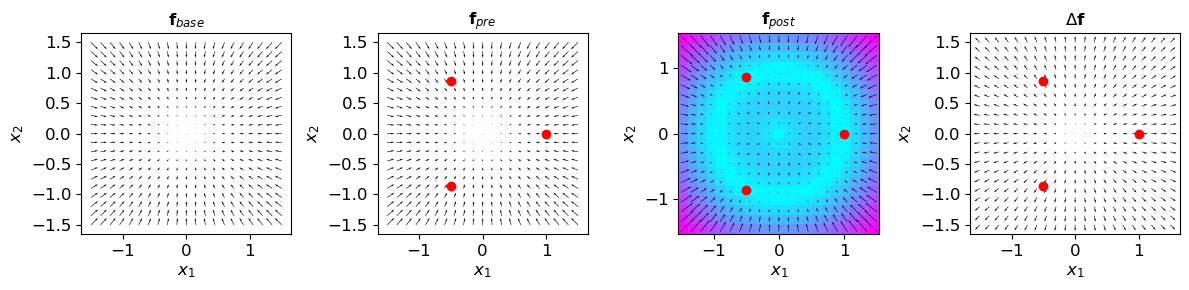

In [6]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=0, u=None)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
flow_post = get_flow(F_POST, RX, u=None)
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

if 'kwta' not in psi_name.lower():
    fig.savefig(f'ms/2_dual_ridge_3fp_{psi_name}_g_{G}.svg')
else:
    fig.savefig(f'ms/2_dual_ridge_3fp_{psi_name}_g_{G}_k_{K}.svg')

Colorbar

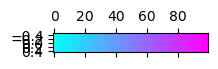

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(2, .25))
ax.matshow(np.arange(100)[None, :], cmap='cool')
ax.set_aspect('auto')
fig.savefig('ms/2_speed_cbar.svg')

## Five fixed points

In [8]:
theta_stars = np.linspace(0, 2*np.pi, 5, endpoint=False)
x_stars = np.array([np.cos(theta_stars), np.sin(theta_stars)]).T

thetas = np.linspace(0, 2*np.pi, 5, endpoint=False)  #[0., 2*np.pi/3, 4*np.pi/3]
xs = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = np.array([0. ,0])
vs = np.tile(v, (len(xs), 1))
u = np.array([0., 0])
us = np.tile(u, (len(xs), 1))

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-8

alphas = train(data, x_stars, lam)

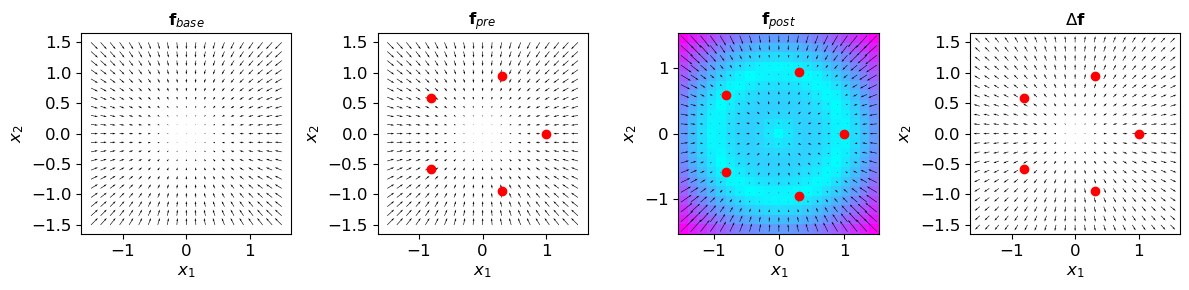

In [9]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=0, u=None)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
flow_post = get_flow(F_POST, RX, u=None)
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

if 'kwta' not in psi_name.lower():
    fig.savefig(f'ms/2_dual_ridge_5fp_{psi_name}_g_{G}.svg')
else:
    fig.savefig(f'ms/2_dual_ridge_5fp_{psi_name}_g_{G}_k_{K}.svg')

## One fixed point

In [10]:
theta_stars = np.linspace(0, 2*np.pi, 3, endpoint=False)
x_stars = np.array([np.cos(theta_stars), np.sin(theta_stars)]).T

thetas = [0.]
xs = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = np.array([0. ,0])
vs = np.tile(v, (len(xs), 1))
u = np.array([0., 0])
us = np.tile(u, (len(xs), 1))

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-8

alphas = train(data, x_stars, lam)

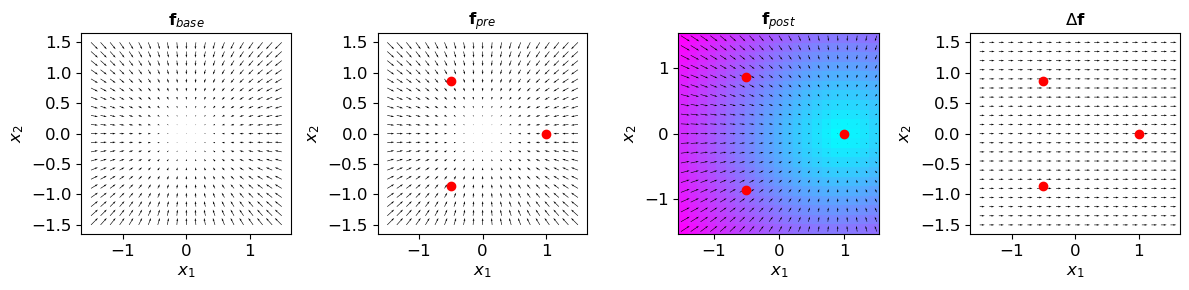

In [11]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=0, u=None)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
flow_post = get_flow(F_POST, RX, u=None)
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

## Two fixed points

In [12]:
theta_stars = np.linspace(0, 2*np.pi, 5, endpoint=False)
x_stars = np.array([np.cos(theta_stars), np.sin(theta_stars)]).T

thetas = [0., np.pi]
xs = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
v = np.array([0. ,0])
vs = np.tile(v, (len(xs), 1))
u = np.array([0., 0])
us = np.tile(u, (len(xs), 1))

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-8

alphas = train(data, x_stars, lam)

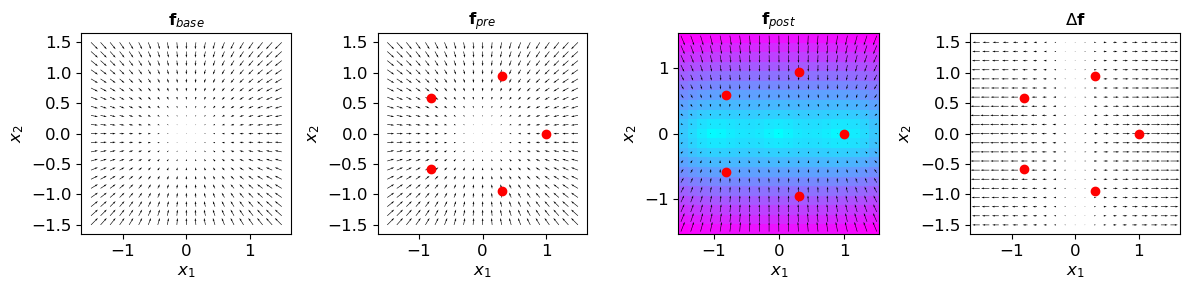

In [13]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=0, u=None)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
flow_post = get_flow(F_POST, RX, u=None)
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()